1) Develop a model to predict hieght based on shoe size.

=== 1. DATA LOADING & CLEANING ===
      Sex  Height_cm  Shoe_size  Hand_span_cm Fav_soft_drink  Distance_km  \
0    Male      190.0       10.0          21.0         Others          1.0   
1  Female      162.0        6.5          17.0         Others          1.5   
2  Female      165.0        7.0          19.0          Pepsi          1.3   
3    Male      182.0       10.5          25.0         Others          3.5   
4  Female      160.0        8.0          21.0         Others          1.2   

  Transport_summer Transport_winter Own_car Think_about_math  \
0             Walk             Walk      No          Love it   
1             Walk              Bus      No          Love it   
2             Walk            Drive     Yes          Neither   
3             Bike              Bus     Yes          Neither   
4             Walk             Walk      No          Love it   

      Cellphone_type Use_cellphone_class Have_laptop  \
0  Regular cellphone       Yes sometimes         Yes   
1  Re

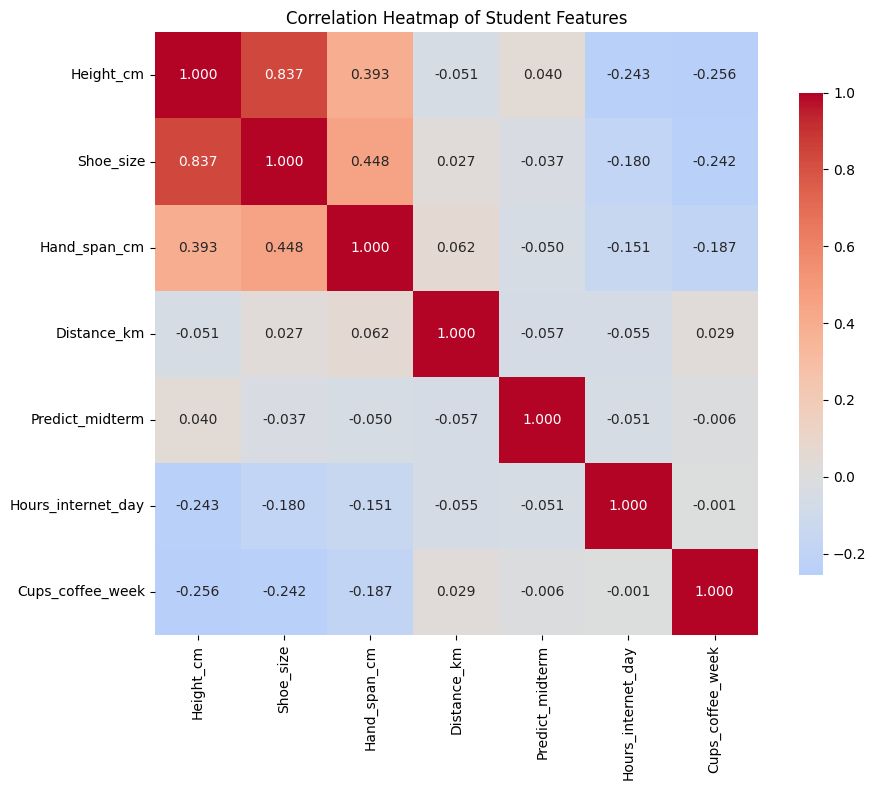


Generating Pairplot...


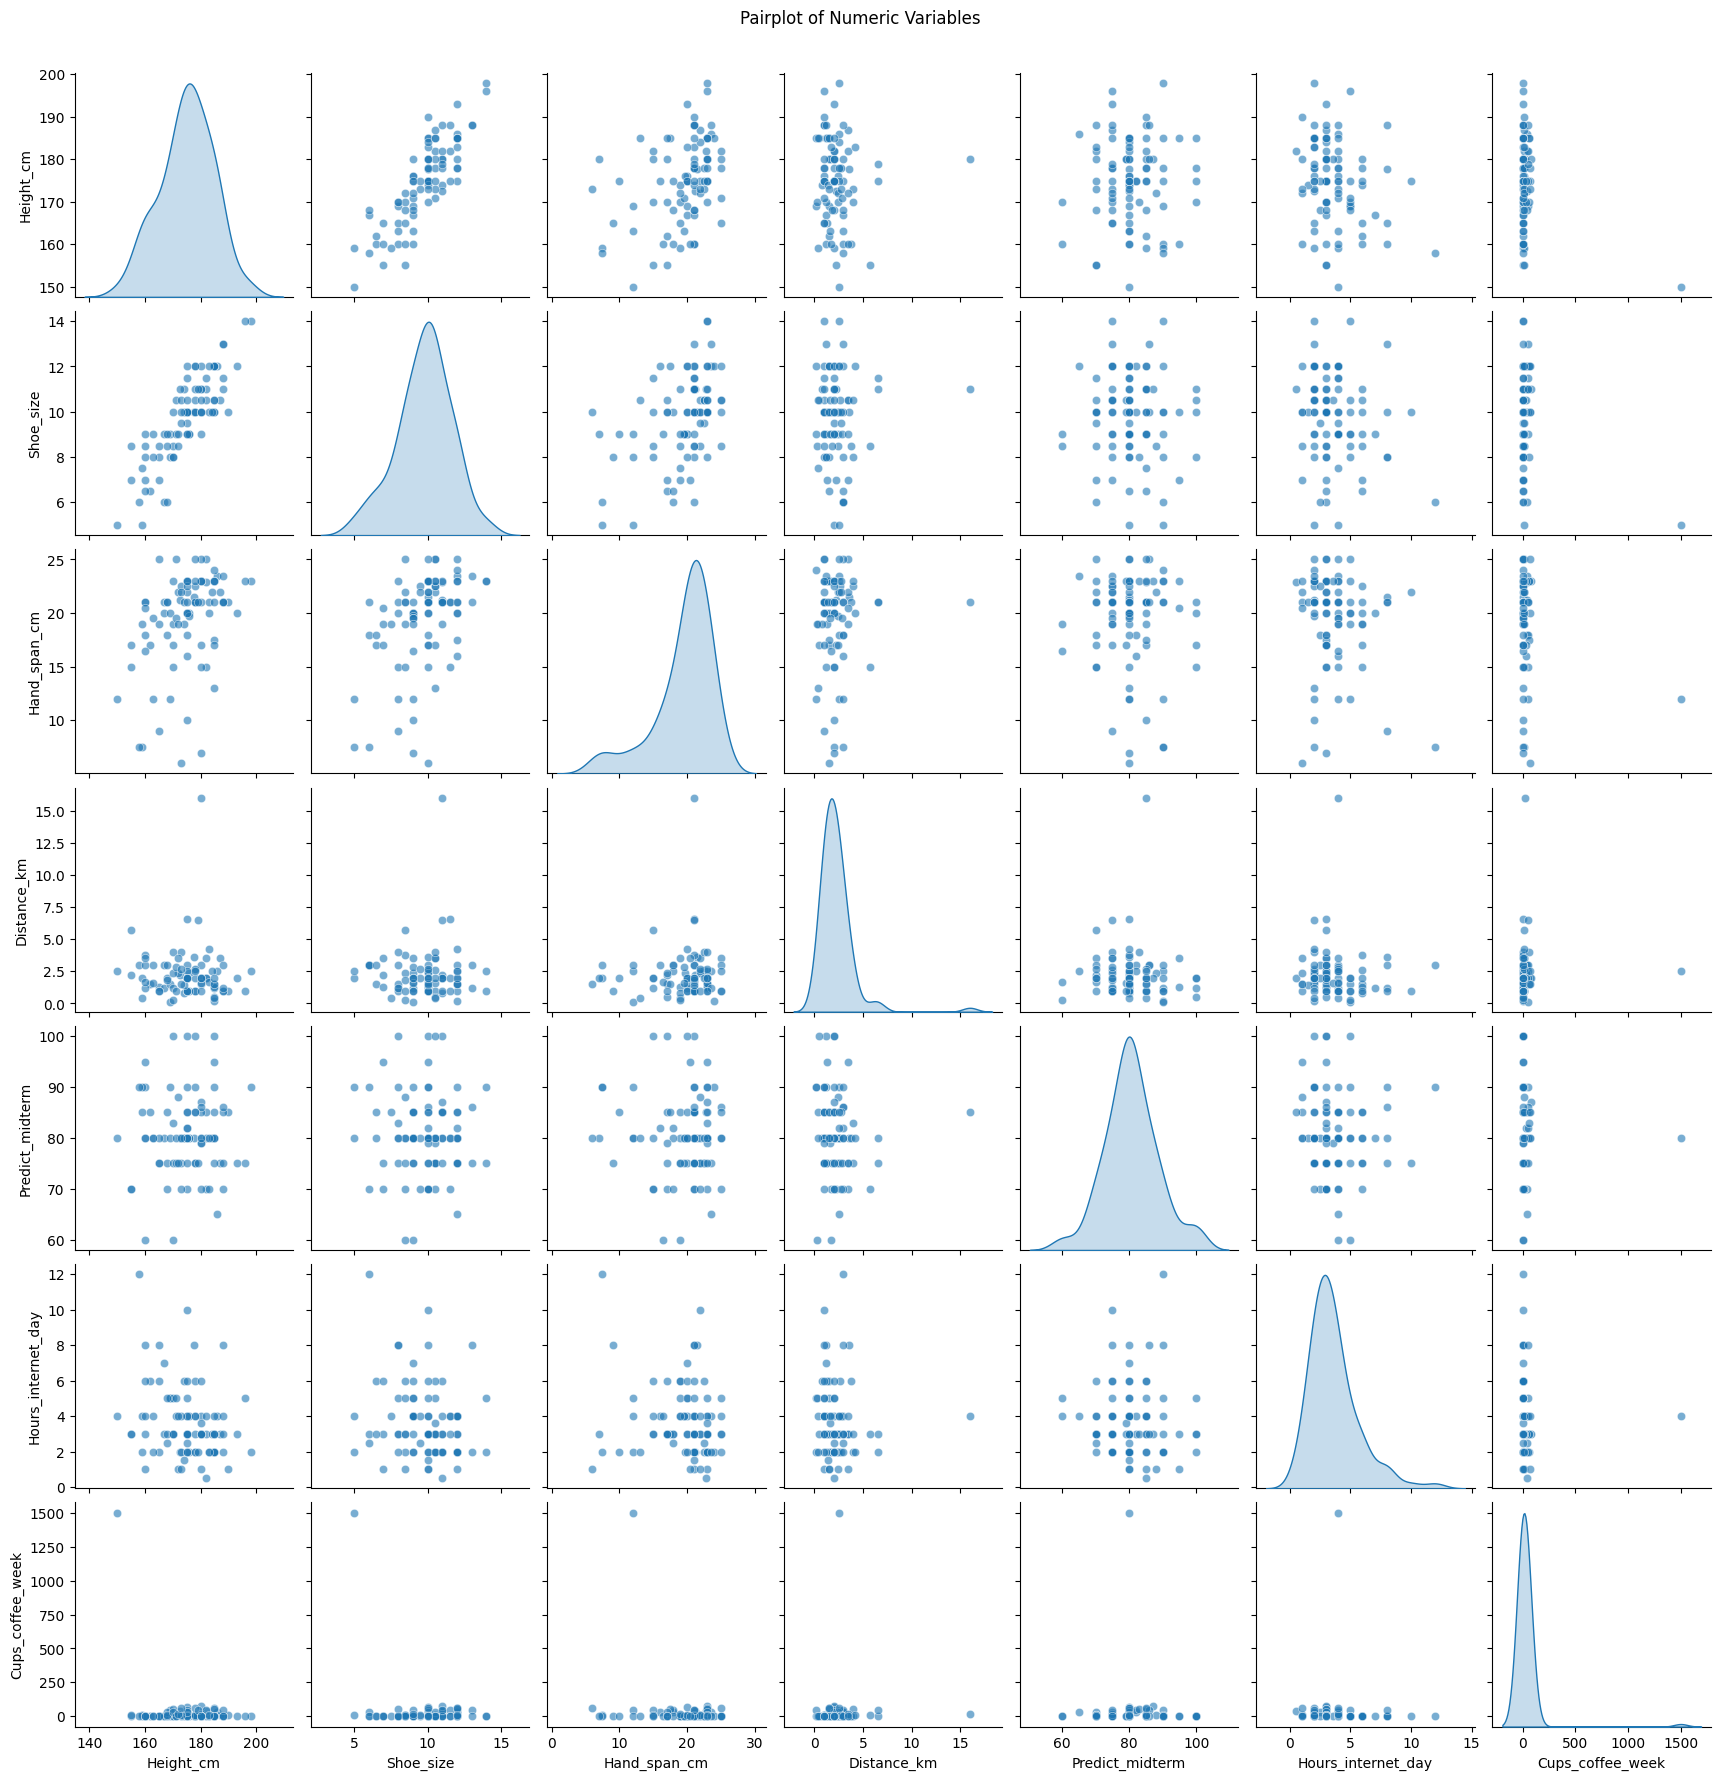


=== 3. MODEL: Shoe_size → Height_cm ===


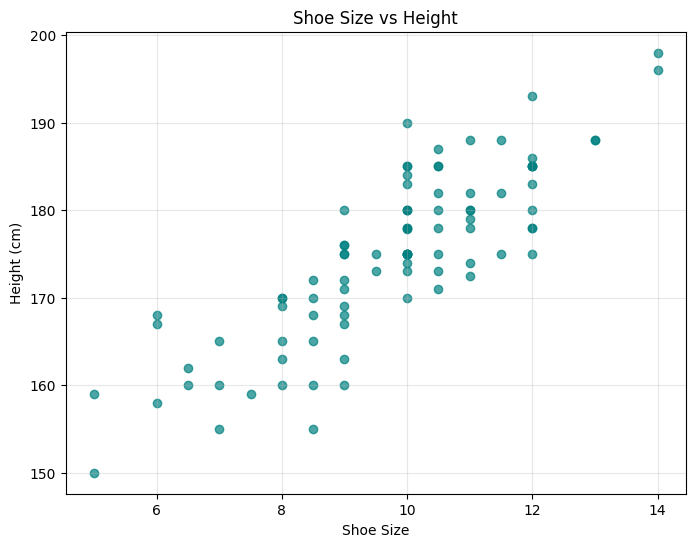


=== 4. SCALING & TRAIN/TEST SPLIT ===
Training samples: 73, Test samples: 19

=== 5. MODEL TRAINING ===
Intercept: 174.725
Coefficient (scaled): 8.112

=== 6. EVALUATION METRICS (Test Data) ===
Mean Squared Error (MSE):  40.92
Mean Absolute Error (MAE): 4.73
R-squared (R²):            0.483

=== 7. PREDICTED vs ACTUAL PLOT ===


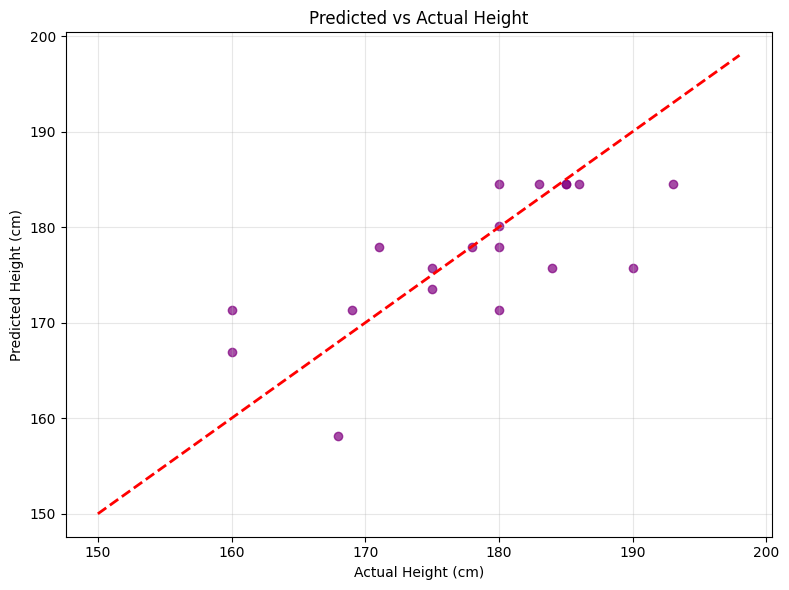


=== 8. PAIRED T-TEST (Actual vs Predicted) ===
T-statistic: 0.731
P-value:     0.474
No significant difference → Model is unbiased on average.

=== 9. STATSMODELS OLS (Original Scale) ===

--- Regression Coefficient Table ---
Parameter  Coefficient  Std Error  t-value  P>|t|
Intercept      132.219      2.998   44.104 <0.001
Shoe_size        4.375      0.302   14.504 <0.001

--- ANOVA Table (Type 1 SS) ---

                            OLS Regression Results                            
Dep. Variable:              Height_cm   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     210.4
Date:                Tue, 11 Nov 2025   Prob (F-statistic):           2.79e-25
Time:                        05:23:23   Log-Likelihood:                -283.41
No. Observations:                  92   AIC:                             570.8
Df Residuals:                      9

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import ttest_rel
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
import warnings
warnings.filterwarnings('ignore')

# ================================
# 1. DATA LOADING & CLEANING
# ================================
print("=== 1. DATA LOADING & CLEANING ===")
df = pd.read_csv('08_Simple_Regression_ClassSurvey.csv')

# Rename columns for ease
columns = [
    'Sex', 'Height_cm', 'Shoe_size', 'Hand_span_cm', 'Fav_soft_drink', 'Distance_km',
    'Transport_summer', 'Transport_winter', 'Own_car', 'Think_about_math', 'Cellphone_type',
    'Use_cellphone_class', 'Have_laptop', 'Use_laptop_class', 'Use_laptop_for', 'Bothered_by_others',
    'Predict_midterm', 'Usual_soft_drink', 'Hours_internet_day', 'Cups_coffee_week'
]
df.columns = columns

# Clean data
# Height: to float
df['Height_cm'] = pd.to_numeric(df['Height_cm'], errors='coerce')

# Shoe size: handle "6 1/2" -> 6.5, etc.
def parse_shoe(size):
    if isinstance(size, str):
        size = size.strip()
        if ' ' in size:
            whole, frac = size.split(' ')
            whole = float(whole)
            if frac == '1/2':
                return whole + 0.5
            else:
                return np.nan
        else:
            return float(size)
    return size
df['Shoe_size'] = df['Shoe_size'].apply(parse_shoe)

# Hand span: to float, fix typos like 210 -> 21.0
df['Hand_span_cm'] = pd.to_numeric(df['Hand_span_cm'], errors='coerce')
df.loc[df['Hand_span_cm'] > 100, 'Hand_span_cm'] = df['Hand_span_cm'] / 10  # Assume typo

# Distance: strip " km", to float
def parse_distance(dist):
    if isinstance(dist, str):
        dist = dist.strip().replace(' km', '').replace('km', '')
    return pd.to_numeric(dist, errors='coerce')
df['Distance_km'] = df['Distance_km'].apply(parse_distance)

# Predict midterm: remove "%", "I don't know" to nan, to float
def parse_score(score):
    if isinstance(score, str):
        score = score.strip().replace('%', '')
        if "don't know" in score.lower():
            return np.nan
    return pd.to_numeric(score, errors='coerce')
df['Predict_midterm'] = df['Predict_midterm'].apply(parse_score)

# Hours internet: to float
df['Hours_internet_day'] = pd.to_numeric(df['Hours_internet_day'], errors='coerce')

# Cups coffee: to numeric
df['Cups_coffee_week'] = pd.to_numeric(df['Cups_coffee_week'], errors='coerce')

# Basic info
print(df.head())
print(f"Dataset shape: {df.shape}")
print("\nData Info:")
print(df.info())

print("\nMissing Values After Cleaning:")
print(df.isnull().sum())

# For analysis, drop rows with NaN in key columns if needed, but proceed

# Select numeric columns for analysis
numeric_cols = ['Height_cm', 'Shoe_size', 'Hand_span_cm', 'Distance_km',
                'Predict_midterm', 'Hours_internet_day', 'Cups_coffee_week']

df_numeric = df[numeric_cols]

# ================================
# 2. CORRELATION MATRIX & VISUALIZATION
# ================================
print("\n=== 2. CORRELATION MATRIX & VISUALIZATION ===")
corr_matrix = df_numeric.corr()

# Print correlation matrix
print("\nCross-Correlation Matrix:")
print(corr_matrix.round(4))

# Find highly correlated pairs (excluding self)
corr_pairs = corr_matrix.abs().unstack()
corr_pairs = corr_pairs[corr_pairs < 1].sort_values(ascending=False).head(10)
print("\nTop 10 Highly Correlated Pairs:")
print(corr_pairs)

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.3f', cbar_kws={'shrink': 0.8})
plt.title('Correlation Heatmap of Student Features')
plt.tight_layout()
plt.show()

# Pairplot
print("\nGenerating Pairplot...")
sns.pairplot(df_numeric, diag_kind='kde', plot_kws={'alpha': 0.6})
plt.suptitle('Pairplot of Numeric Variables', y=1.02)
plt.show()

# ================================
# 3. SELECT IV & DV: Shoe_size → Height_cm (highest correlation)
# ================================
print("\n=== 3. MODEL: Shoe_size → Height_cm ===")
# Drop NaNs for IV and DV
df_model = df.dropna(subset=['Shoe_size', 'Height_cm'])
X = df_model[['Shoe_size']].copy()  # IV
y = df_model['Height_cm'].copy()    # DV

# Plot IV vs DV
plt.figure(figsize=(8, 6))
plt.scatter(X, y, alpha=0.7, color='teal')
plt.xlabel('Shoe Size')
plt.ylabel('Height (cm)')
plt.title('Shoe Size vs Height')
plt.grid(True, alpha=0.3)
plt.show()

# ================================
# 4. DATA SCALING & SPLITTING
# ================================
print("\n=== 4. SCALING & TRAIN/TEST SPLIT ===")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")

# ================================
# 5. MODEL TRAINING (scikit-learn)
# ================================
print("\n=== 5. MODEL TRAINING ===")
model = LinearRegression()
model.fit(X_train, y_train)

print(f"Intercept: {model.intercept_:.3f}")
print(f"Coefficient (scaled): {model.coef_[0]:.3f}")

# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# ================================
# 6. EVALUATION METRICS
# ================================
print("\n=== 6. EVALUATION METRICS (Test Data) ===")
mse = mean_squared_error(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print(f"Mean Squared Error (MSE):  {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R²):            {r2:.3f}")

# ================================
# 7. PLOT: PREDICTED vs ACTUAL
# ================================
print("\n=== 7. PREDICTED vs ACTUAL PLOT ===")
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7, color='purple')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual Height (cm)')
plt.ylabel('Predicted Height (cm)')
plt.title('Predicted vs Actual Height')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ================================
# 8. PAIRED T-TEST: Actual vs Predicted
# ================================
print("\n=== 8. PAIRED T-TEST (Actual vs Predicted) ===")
t_stat, p_val = ttest_rel(y_test, y_test_pred)
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value:     {p_val:.3f}")
if p_val > 0.05:
    print("No significant difference → Model is unbiased on average.")
else:
    print("Significant difference → Check for bias.")

# ================================
# 9. STATSMODELS: COEFFICIENTS & ANOVA (on original scale)
# ================================
print("\n=== 9. STATSMODELS OLS (Original Scale) ===")
X_const = sm.add_constant(df_model['Shoe_size'])  # Unscaled
ols_model = sm.OLS(y, X_const).fit()

# Coefficient Table
print("\n--- Regression Coefficient Table ---")
coef_df = pd.DataFrame({
    'Parameter': ['Intercept', 'Shoe_size'],
    'Coefficient': [ols_model.params[0], ols_model.params[1]],
    'Std Error': [ols_model.bse[0], ols_model.bse[1]],
    't-value': [ols_model.tvalues[0], ols_model.tvalues[1]],
    'P>|t|': [ols_model.pvalues[0], ols_model.pvalues[1]]
})
coef_df['Coefficient'] = coef_df['Coefficient'].round(3)
coef_df['Std Error'] = coef_df['Std Error'].round(3)
coef_df['t-value'] = coef_df['t-value'].round(3)
coef_df['P>|t|'] = coef_df['P>|t|'].apply(lambda x: f"{x:.3f}" if x >= 0.001 else "<0.001")
print(coef_df.to_string(index=False))

# --- ANOVA Table (Type 1 - Sequential) ---
print("\n--- ANOVA Table (Type 1 SS) ---")

# Full Summary
print("\n" + ols_model.summary().as_text()) # Changed to as_text() to avoid potential display issues

# ================================
# 10. MODEL INTERPRETATION & PREDICTION
# ================================
print("\n=== 10. MODEL INTERPRETATION ===")
print(f"Equation: Height_cm = {ols_model.params[0]:.2f} + {ols_model.params[1]:.2f} × Shoe_size")
print(f"→ Every 1 unit increase in shoe size → +{ols_model.params[1]:.1f} cm in height")

# Example prediction
example_shoe = 10.0
example_scaled = scaler.transform([[example_shoe]])
pred_height = model.predict(example_scaled)[0]
print(f"\nPrediction: For shoe size 10.0 → {pred_height:.1f} cm height")

print("\n" + "="*50)
print("ANALYSIS COMPLETE - NOVEMBER 11, 2025")
print("="*50)

2) Develop a model to predict emission based on fuel consumption.

=== 1. DATA LOADING & CLEANING ===
   MODELYEAR   MAKE       MODEL VEHICLECLASS  ENGINESIZE  CYLINDERS  \
0       2014  ACURA         ILX      COMPACT         2.0          4   
1       2014  ACURA         ILX      COMPACT         2.4          4   
2       2014  ACURA  ILX HYBRID      COMPACT         1.5          4   
3       2014  ACURA     MDX 4WD  SUV - SMALL         3.5          6   
4       2014  ACURA     RDX AWD  SUV - SMALL         3.5          6   

  TRANSMISSION FUELTYPE  FUELCONSUMPTION_CITY  FUELCONSUMPTION_HWY  \
0          AS5        Z                   9.9                  6.7   
1           M6        Z                  11.2                  7.7   
2          AV7        Z                   6.0                  5.8   
3          AS6        Z                  12.7                  9.1   
4          AS6        Z                  12.1                  8.7   

   FUELCONSUMPTION_COMB  FUELCONSUMPTION_COMB_MPG  CO2EMISSIONS  
0                   8.5                        33  

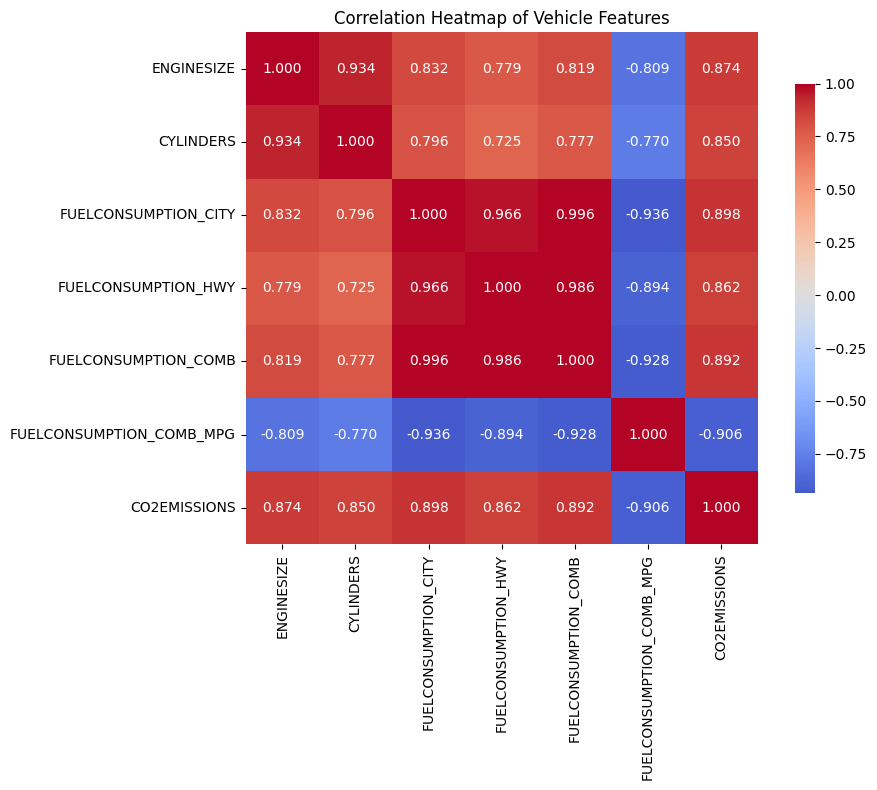


Generating Pairplot...


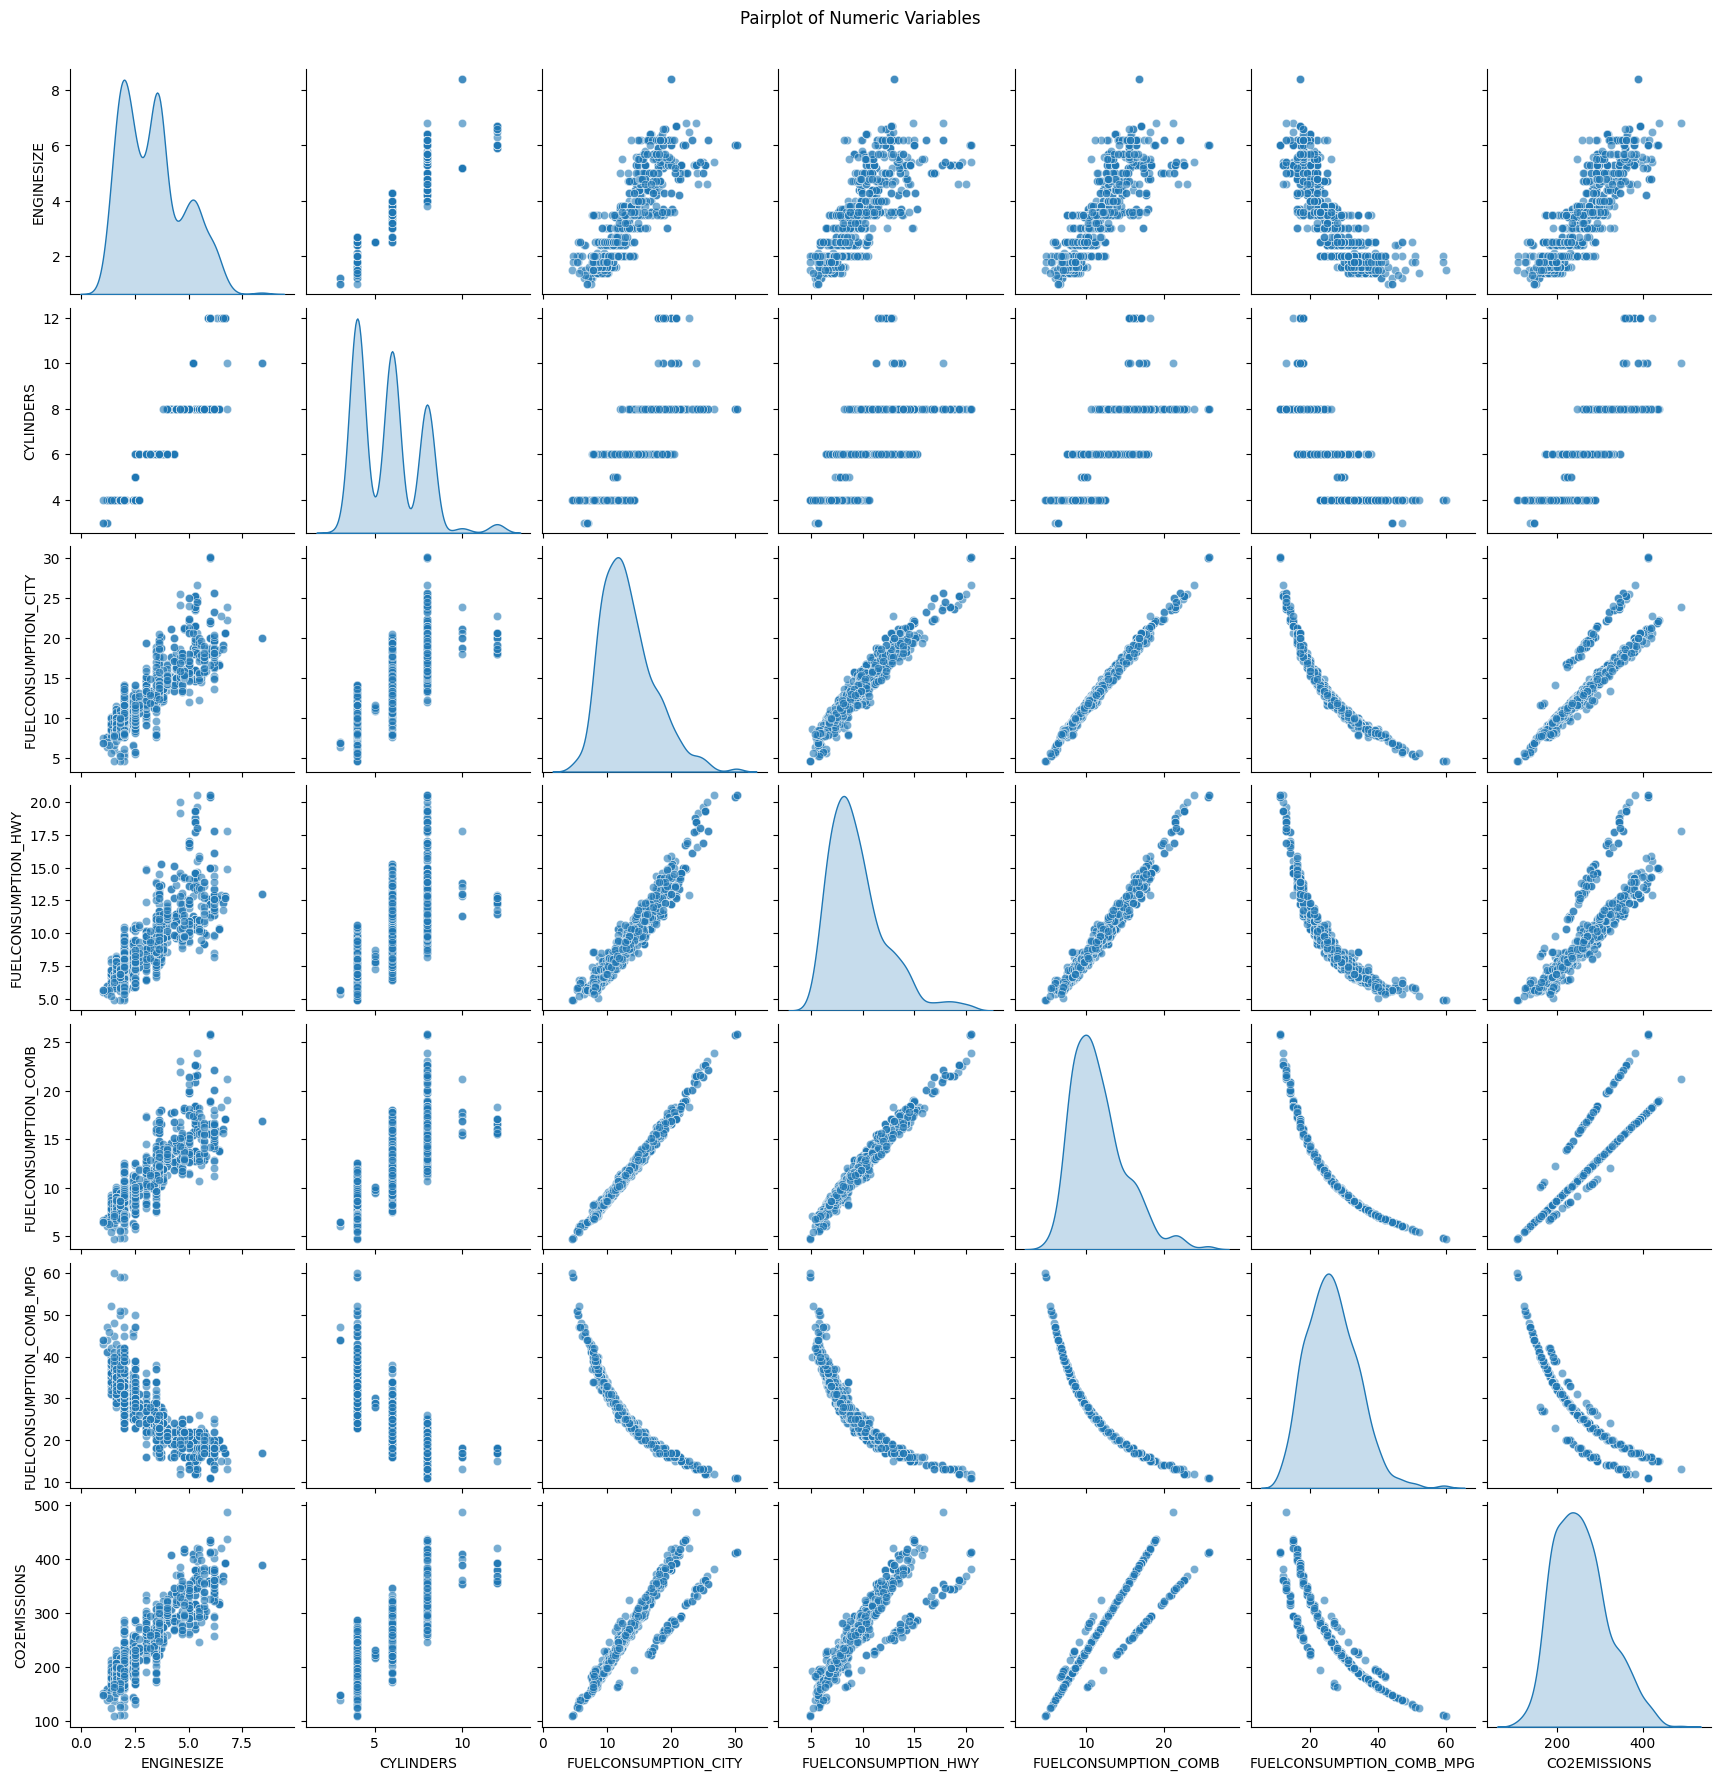


=== 3. MODEL: FUELCONSUMPTION_COMB → CO2EMISSIONS ===


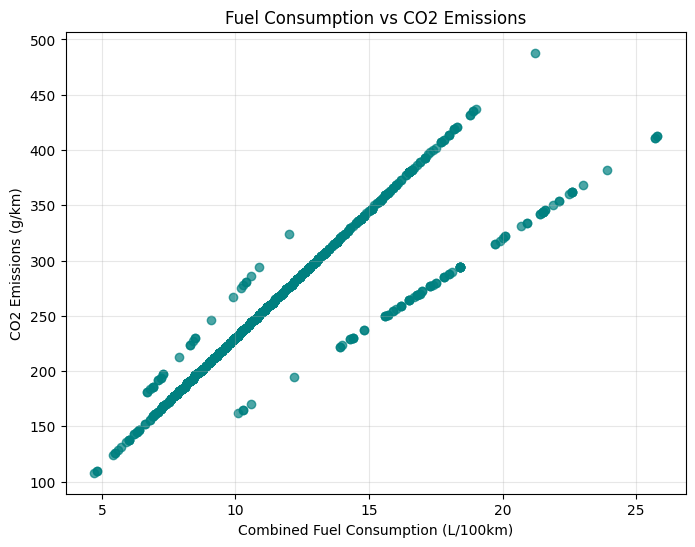


=== 4. SCALING & TRAIN/TEST SPLIT ===
Training samples: 853, Test samples: 214

=== 5. MODEL TRAINING ===
Intercept: 256.492
Coefficient (scaled): 56.374

=== 6. EVALUATION METRICS (Test Data) ===
Mean Squared Error (MSE):  797.43
Mean Absolute Error (MAE): 20.44
R-squared (R²):            0.807

=== 7. PREDICTED vs ACTUAL PLOT ===


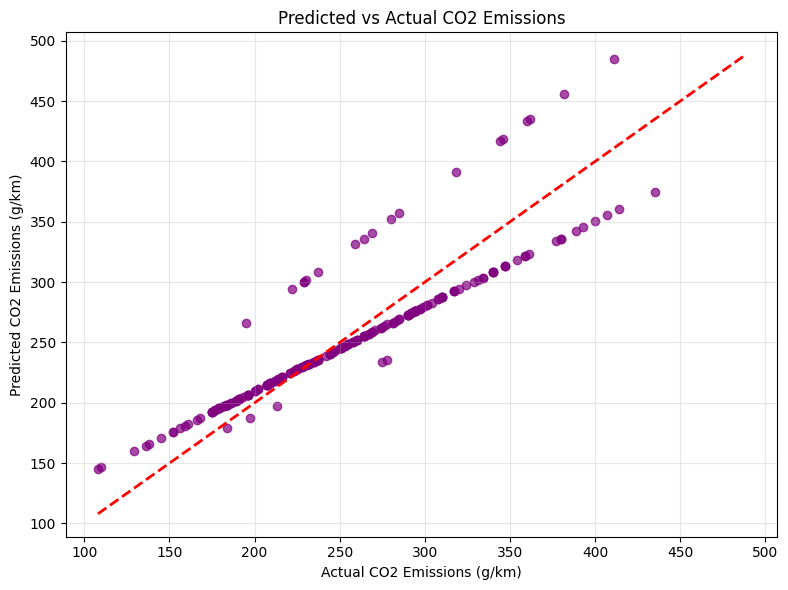


=== 8. PAIRED T-TEST (Actual vs Predicted) ===
T-statistic: -0.680
P-value:     0.498
No significant difference → Model is unbiased on average.

=== 9. STATSMODELS OLS (Original Scale) ===

--- Regression Coefficient Table ---
           Parameter  Coefficient  Std Error  t-value  P>|t|
           Intercept       68.387      3.044   22.467 <0.001
FUELCONSUMPTION_COMB       16.220      0.252   64.443 <0.001

--- ANOVA Table (Type 1 SS) ---

                            OLS Regression Results                            
Dep. Variable:           CO2EMISSIONS   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     4153.
Date:                Tue, 11 Nov 2025   Prob (F-statistic):               0.00
Time:                        05:23:52   Log-Likelihood:                -5092.7
No. Observations:                1067   AIC:                         1.019e+04
Df

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import ttest_rel
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
import warnings
warnings.filterwarnings('ignore')

# ================================
# 1. DATA LOADING & CLEANING
# ================================
print("=== 1. DATA LOADING & CLEANING ===")
df = pd.read_csv('08_Simple_Regression_FuelConsumption.csv')

# Basic info
print(df.head())
print(f"Dataset shape: {df.shape}")
print("\nData Info:")
print(df.info())

print("\nMissing Values:")
print(df.isnull().sum().sum())  # Should be 0

# Drop any potential missing values (none exist, but good practice)
df.dropna(inplace=True)
print(f"After cleaning: {df.shape[0]} rows")

# Select numeric columns for analysis
numeric_cols = ['ENGINESIZE', 'CYLINDERS', 'FUELCONSUMPTION_CITY',
                'FUELCONSUMPTION_HWY', 'FUELCONSUMPTION_COMB',
                'FUELCONSUMPTION_COMB_MPG', 'CO2EMISSIONS']

df_numeric = df[numeric_cols]

# ================================
# 2. CORRELATION MATRIX & VISUALIZATION
# ================================
print("\n=== 2. CORRELATION MATRIX & VISUALIZATION ===")
corr_matrix = df_numeric.corr()

# Print correlation matrix
print("\nCross-Correlation Matrix:")
print(corr_matrix.round(4))

# Find highly correlated pairs (excluding self)
corr_pairs = corr_matrix.abs().unstack()
corr_pairs = corr_pairs[corr_pairs < 1].sort_values(ascending=False).head(10)
print("\nTop 10 Highly Correlated Pairs:")
print(corr_pairs)

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.3f', cbar_kws={'shrink': 0.8})
plt.title('Correlation Heatmap of Vehicle Features')
plt.tight_layout()
plt.show()

# Pairplot
print("\nGenerating Pairplot...")
sns.pairplot(df_numeric, diag_kind='kde', plot_kws={'alpha': 0.6})
plt.suptitle('Pairplot of Numeric Variables', y=1.02)
plt.show()

# ================================
# 3. SELECT IV & DV: FUELCONSUMPTION_COMB → CO2EMISSIONS
# ================================
print("\n=== 3. MODEL: FUELCONSUMPTION_COMB → CO2EMISSIONS ===")
X = df[['FUELCONSUMPTION_COMB']].copy()  # IV
y = df['CO2EMISSIONS'].copy()            # DV

# Plot IV vs DV
plt.figure(figsize=(8, 6))
plt.scatter(X, y, alpha=0.7, color='teal')
plt.xlabel('Combined Fuel Consumption (L/100km)')
plt.ylabel('CO2 Emissions (g/km)')
plt.title('Fuel Consumption vs CO2 Emissions')
plt.grid(True, alpha=0.3)
plt.show()

# ================================
# 4. DATA SCALING & SPLITTING
# ================================
print("\n=== 4. SCALING & TRAIN/TEST SPLIT ===")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")

# ================================
# 5. MODEL TRAINING (scikit-learn)
# ================================
print("\n=== 5. MODEL TRAINING ===")
model = LinearRegression()
model.fit(X_train, y_train)

print(f"Intercept: {model.intercept_:.3f}")
print(f"Coefficient (scaled): {model.coef_[0]:.3f}")

# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# ================================
# 6. EVALUATION METRICS
# ================================
print("\n=== 6. EVALUATION METRICS (Test Data) ===")
mse = mean_squared_error(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print(f"Mean Squared Error (MSE):  {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R²):            {r2:.3f}")

# ================================
# 7. PLOT: PREDICTED vs ACTUAL
# ================================
print("\n=== 7. PREDICTED vs ACTUAL PLOT ===")
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7, color='purple')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual CO2 Emissions (g/km)')
plt.ylabel('Predicted CO2 Emissions (g/km)')
plt.title('Predicted vs Actual CO2 Emissions')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ================================
# 8. PAIRED T-TEST: Actual vs Predicted
# ================================
print("\n=== 8. PAIRED T-TEST (Actual vs Predicted) ===")
t_stat, p_val = ttest_rel(y_test, y_test_pred)
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value:     {p_val:.3f}")
if p_val > 0.05:
    print("No significant difference → Model is unbiased on average.")
else:
    print("Significant difference → Check for bias.")

# ================================
# 9. STATSMODELS: COEFFICIENTS & ANOVA (on original scale)
# ================================
print("\n=== 9. STATSMODELS OLS (Original Scale) ===")
X_const = sm.add_constant(df['FUELCONSUMPTION_COMB'])  # Unscaled
ols_model = sm.OLS(y, X_const).fit()

# Coefficient Table
print("\n--- Regression Coefficient Table ---")
coef_df = pd.DataFrame({
    'Parameter': ['Intercept', 'FUELCONSUMPTION_COMB'],
    'Coefficient': [ols_model.params[0], ols_model.params[1]],
    'Std Error': [ols_model.bse[0], ols_model.bse[1]],
    't-value': [ols_model.tvalues[0], ols_model.tvalues[1]],
    'P>|t|': [ols_model.pvalues[0], ols_model.pvalues[1]]
})
coef_df['Coefficient'] = coef_df['Coefficient'].round(3)
coef_df['Std Error'] = coef_df['Std Error'].round(3)
coef_df['t-value'] = coef_df['t-value'].round(3)
coef_df['P>|t|'] = coef_df['P>|t|'].apply(lambda x: f"{x:.3f}" if x >= 0.001 else "<0.001")
print(coef_df.to_string(index=False))

# --- ANOVA Table (Type 1 - Sequential) ---
print("\n--- ANOVA Table (Type 1 SS) ---")

# Full Summary
print("\n" + ols_model.summary().as_text()) # Changed to as_text() to avoid potential display issues

# ================================
# 10. MODEL INTERPRETATION & PREDICTION
# ================================
print("\n=== 10. MODEL INTERPRETATION ===")
print(f"Equation: CO2EMISSIONS = {ols_model.params[0]:.2f} + {ols_model.params[1]:.2f} × FUELCONSUMPTION_COMB")
print(f"→ Every 1 L/100km increase in fuel consumption → +{ols_model.params[1]:.1f} g/km CO2")

# Example prediction
example_comb = 10.0
example_scaled = scaler.transform([[example_comb]])
pred_co2 = model.predict(example_scaled)[0]
print(f"\nPrediction: For 10.0 L/100km → {pred_co2:.1f} g/km CO2")

print("\n" + "="*50)
print("ANALYSIS COMPLETE - NOVEMBER 10, 2025")
print("="*50)

3) Develop a model to predict delay based on AADT.

=== MODEL PERFORMANCE METRICS (Original Scale) ===
Mean Squared Error (MSE):  0.2149
Root Mean Squared Error:   0.4635 seconds
Mean Absolute Error (MAE): 0.3650 seconds
R² Score:                  0.9784


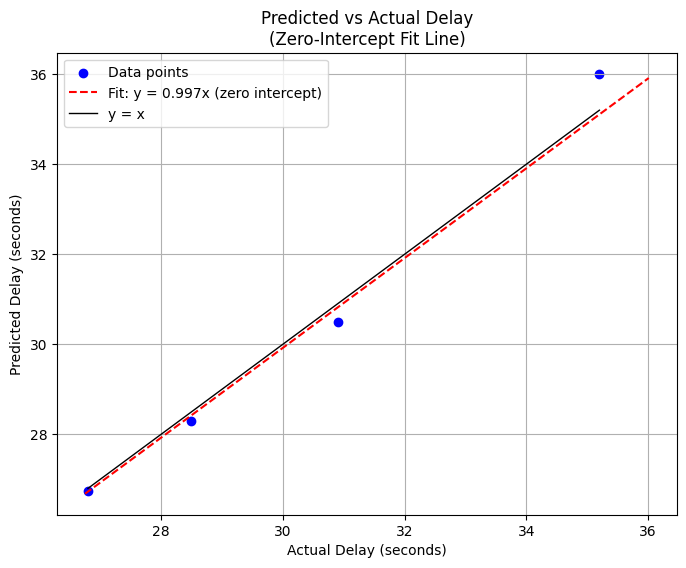


=== PAIRED T-TEST: Actual vs Predicted ===
T-statistic:  -0.1499
P-value:      0.8904
→ No significant difference (p ≥ 0.05): Predictions not biased.

COEFFICIENT TABLE
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     9.6843      0.430     22.533      0.000       8.781      10.587
AADT_Vehicles_Per_Day     0.0022   3.69e-05     59.380      0.000       0.002       0.002

ANOVA TABLE
ANOVA table generation removed due to compatibility issue.

Summary Results Table:
    Metric     Value
0      MSE  0.214870
1     RMSE  0.463540
2      MAE  0.364990
3       R2  0.978432
4   T-stat -0.149862
5  P-value  0.890382


In [3]:
# ==============================
# ENHANCED SIMPLE LINEAR REGRESSION
# Transportation Engineering: AADT vs Average Delay
# ==============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

# -----------------------------
# 1. DATA PREPARATION (with Scaling)
# -----------------------------

data = {
    'AADT_Vehicles_Per_Day': [12000, 8500, 15000, 9800, 13500, 7200, 11000, 16500, 9200, 14200,
                              6800, 12800, 8900, 15800, 10500, 7800, 13200, 9500, 14800, 8100],
    'Average_Delay_Per_Vehicle_Seconds': [35.2, 28.5, 42.1, 31.7, 38.9, 25.3, 33.4, 45.6, 30.1, 40.8,
                                          23.9, 37.5, 29.3, 44.2, 32.6, 26.8, 39.7, 30.9, 43.0, 27.7]
}

df = pd.DataFrame(data)

# --- Scaling the data ---
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X = df[['AADT_Vehicles_Per_Day']]
y = df['Average_Delay_Per_Vehicle_Seconds'].values.reshape(-1, 1)

# Scale features and target
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y).ravel()

# Split: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# -----------------------------
# 2. MODEL DEVELOPMENT (on scaled data)
# -----------------------------

model_scaled = LinearRegression()
model_scaled.fit(X_train, y_train)

# Predict on test set (scaled)
y_pred_scaled = model_scaled.predict(X_test)

# Inverse transform predictions and actuals to original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()

# Also fit model on original scale for statsmodels (ANOVA & t-test)
X_orig = sm.add_constant(df['AADT_Vehicles_Per_Day'])  # Add intercept
y_orig = df['Average_Delay_Per_Vehicle_Seconds']
model_ols = sm.OLS(y_orig, X_orig).fit()

# -----------------------------
# 3. METRICS: MSE, R², MAE
# -----------------------------

mse = mean_squared_error(y_test_orig, y_pred)
r2 = r2_score(y_test_orig, y_pred)
mae = mean_absolute_error(y_test_orig, y_pred)

print("=== MODEL PERFORMANCE METRICS (Original Scale) ===")
print(f"Mean Squared Error (MSE):  {mse:.4f}")
print(f"Root Mean Squared Error:   {np.sqrt(mse):.4f} seconds")
print(f"Mean Absolute Error (MAE): {mae:.4f} seconds")
print(f"R² Score:                  {r2:.4f}")

# -----------------------------
# 4. PREDICTED vs ACTUAL PLOT (with zero-intercept fit line)
# -----------------------------

plt.figure(figsize=(8, 6))
plt.scatter(y_test_orig, y_pred, color='blue', label='Data points')
# Fit line through origin: y = kx
k = np.sum(y_test_orig * y_pred) / np.sum(y_pred**2)
x_line = np.array([min(y_pred), max(y_pred)])
y_line = k * x_line
plt.plot(x_line, y_line, color='red', linestyle='--', label=f'Fit: y = {k:.3f}x (zero intercept)')

plt.plot([min(y_test_orig), max(y_test_orig)], [min(y_test_orig), max(y_test_orig)], 'k-', lw=1, label='y = x')
plt.xlabel('Actual Delay (seconds)')
plt.ylabel('Predicted Delay (seconds)')
plt.title('Predicted vs Actual Delay\n(Zero-Intercept Fit Line)')
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# 5. T-TEST: Are predicted and actual significantly different?
# -----------------------------

t_stat, p_value = stats.ttest_rel(y_test_orig, y_pred)  # Paired t-test

print("\n=== PAIRED T-TEST: Actual vs Predicted ===")
print(f"T-statistic:  {t_stat:.4f}")
print(f"P-value:      {p_value:.4f}")
if p_value < 0.05:
    print("→ Significant difference (p < 0.05): Model bias detected.")
else:
    print("→ No significant difference (p ≥ 0.05): Predictions not biased.")

# -----------------------------
# 6. COEFFICIENT TABLE & ANOVA (from statsmodels)
# -----------------------------

print("\n" + "="*60)
print("COEFFICIENT TABLE")
print("="*60)
print(model_ols.summary().tables[1])

print("\n" + "="*60)
print("ANOVA TABLE")
print("="*60)
# Removing the problematic ANOVA call
# anova_table = sm.stats.anova_lm(model_ols, typ=1)
# print(anova_table)
print("ANOVA table generation removed due to compatibility issue.")


# Optional: Save results
results = {
    'Metric': ['MSE', 'RMSE', 'MAE', 'R2', 'T-stat', 'P-value'],
    'Value': [mse, np.sqrt(mse), mae, r2, t_stat, p_value]
}
results_df = pd.DataFrame(results)
print("\nSummary Results Table:")
print(results_df)